# Start with some Regressiona and Tree Methods

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats   
from scipy.stats import norm
 
import sklearn
import optuna
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

## Evaluation Metric

In [3]:
def spearman(y_train, y_pred):
    return stats.spearmanr(y_train, y_pred)[0]

scorer = make_scorer(spearman, greater_is_better=True)

## Train and Test Datasets

In [4]:
df_train = pd.read_csv('../input/novozymes-enzyme-stability-prediction/train.csv').drop(['data_source'], axis=1)
df_test = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv').drop(['data_source'], axis=1)
submission = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')

In [5]:
print(f"Train dataframe has shape: {df_train.shape}")
print(f"Test dataframe has shape:  {df_test.shape}")
print(f"Submission dataframe has shape : {submission.shape}")

Train dataframe has shape: (31390, 4)
Test dataframe has shape:  (2413, 3)
Submission dataframe has shape : (2413, 2)


## Output Variable

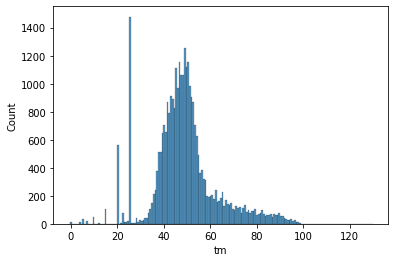

In [6]:
sns.histplot(data=df_train, x='tm')
plt.show()

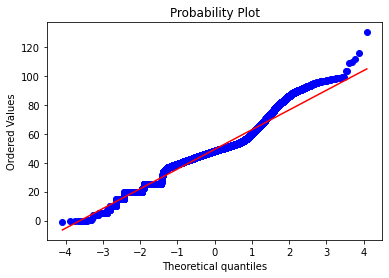

In [7]:
stats.probplot(df_train['tm'], plot=plt)
plt.show()

## pH

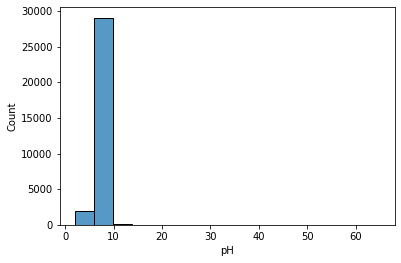

In [8]:
sns.histplot(data=df_train, x='pH')
plt.show()

## Protein Sequence

In [9]:
df_train['protein_sequence'][0]

'AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR'

### Letter Count

In [10]:
df_train['letter_count'] = df_train.apply(lambda row: len(set(row['protein_sequence'])), axis=1)
df_test['letter_count'] = df_test.apply(lambda row: len(set(row['protein_sequence'])), axis=1)
df_train.head()

,seq_id,protein_sequence,pH,tm,letter_count
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,20
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,19
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,20
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,20


In [11]:
df_train['letter_count'].unique()

array([20, 19, 15, 16, 17, 18, 11, 13, 12,  9, 14,  5,  6])

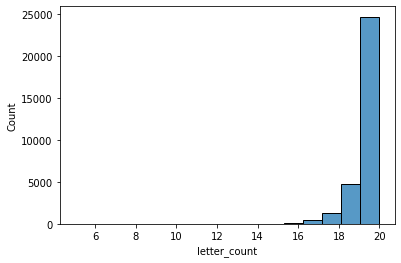

In [12]:
sns.histplot(df_train, x='letter_count')
plt.show()

### Amino Acids Notations

In [13]:
df_train['protein_sequence'][0]

'AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR'

In [14]:
amino_acids = sorted(list(set(df_train['protein_sequence'][0])))
amino_acids

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [15]:
for letter in amino_acids:
    df_train[letter] = df_train.apply(lambda row: row['protein_sequence'].count(letter), axis=1)
df_train.head()

,seq_id,protein_sequence,pH,tm,letter_count,A,C,D,E,F,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,20,45,1,13,30,13,...,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,19,28,0,10,52,6,...,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,20,50,9,27,32,21,...,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,20,5,19,29,12,...,2,9,16,9,10,16,19,14,3,4
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,20,86,14,78,78,32,...,31,65,128,54,63,148,120,124,16,47


In [16]:
for letter in amino_acids:
    df_test[letter] = df_test.apply(lambda row: row['protein_sequence'].count(letter), axis=1)
df_test.head()

,seq_id,protein_sequence,pH,letter_count,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,4,15,8,10,19,...,0,19,17,13,3,18,8,13,6,6
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,18,22,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,5,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,4,15,7,11,19,...,0,19,17,13,3,18,8,13,6,6


## Data Preprocess

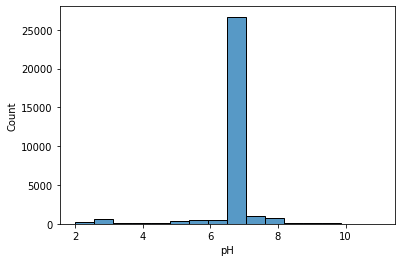

In [17]:
#remove instances with abnormal pH values
df_1 = df_train.copy()

df_1 = df_1[df_1['pH']<=14].copy()
df_1 = df_1[0<=df_1['pH']].copy()

sns.histplot(df_1['pH'])
plt.show()

In [18]:
y_train = df_1['tm'].copy()

features = list(df_1.columns[2:])
features.remove('tm')
X_train = df_1[features].copy()
X_test = df_test[features].copy()

## Models

In [19]:
def cv_score(model):
    kf = KFold(5, shuffle=True, random_state=0).get_n_splits(X_train.values)
    score = cross_val_score(model, X_train.values, y_train, scoring=scorer, cv=kf)
    return score

### Lasso Regression

In [20]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, max_iter=5000, random_state=0))
score = cv_score(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.2239 (0.0664)


### Ridge Regression

In [21]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.1, max_iter=5000, random_state=0))
score = cv_score(ridge)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.2239 (0.0664)


### Elastic Net

In [22]:
ENet = make_pipeline(RobustScaler(), ElasticNet(max_iter=5000, alpha=0.05, l1_ratio=0.1, random_state=0))
score = cv_score(ENet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ElasticNet score: 0.2240 (0.0658)


### Decision Tree

In [23]:
DT = DecisionTreeRegressor(min_samples_leaf = 16,
                           min_samples_split = 17,
                           max_features = 3,
                           max_depth = 25,
                           random_state = 0)
score = cv_score(DT)
print("Decision Tree score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Decision Tree score: 0.2853 (0.0654)


### Random Forest

In [24]:
RF = RandomForestRegressor(n_estimators = 200,
                           max_depth = 29,
                           min_samples_split = 17,
                           min_samples_leaf = 2,
                           max_features = 3,
                           random_state = 0)
score = cv_score(RF)
print("Random Forest score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Random Forest score: 0.3976 (0.0808)


### Gradient Boosting

In [25]:
GBT = GradientBoostingRegressor(n_estimators = 200,
                                max_depth = 28,
                                learning_rate = 0.01,
                                min_samples_leaf = 4,
                                min_samples_split = 3,
                                max_features = 2,
                                random_state = 0,
                                subsample = 1.0)
score = cv_score(GBT)
print("Gradient Boosting score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Gradient Boosting score: 0.4029 (0.0776)


### XGBoosting

In [26]:
xgb = XGBRegressor(max_depth = 12,
                   n_estimators = 200,
                   subsample = 0.7,
                   learning_rate = 0.1,
                   random_state = 0)
score = cv_score(xgb)
print("XGBoosting score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBoosting score: 0.4028 (0.0662)


# Light boost

In [27]:
light = LGBMRegressor()
score = cv_score(light)
print("XGBoosting score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBoosting score: 0.3533 (0.0625)


# Cat boost

In [28]:
cat = CatBoostRegressor()
score = cv_score(cat)
print("Cat boost score : {:.4f}({:.4f})".format(score.mean(),score.std()))

Learning rate set to 0.068025
0:	learn: 14.3633782	total: 72.1ms	remaining: 1m 12s
1:	learn: 14.1721589	total: 83.2ms	remaining: 41.5s
2:	learn: 13.9671550	total: 93.7ms	remaining: 31.1s
3:	learn: 13.7787539	total: 104ms	remaining: 25.9s
4:	learn: 13.6117164	total: 114ms	remaining: 22.8s
5:	learn: 13.4627911	total: 125ms	remaining: 20.7s
6:	learn: 13.3291788	total: 135ms	remaining: 19.1s
7:	learn: 13.1806130	total: 145ms	remaining: 18s
8:	learn: 13.0561103	total: 156ms	remaining: 17.1s
9:	learn: 12.9416440	total: 167ms	remaining: 16.5s
10:	learn: 12.8205544	total: 178ms	remaining: 16s
11:	learn: 12.7152708	total: 190ms	remaining: 15.6s
12:	learn: 12.6204679	total: 202ms	remaining: 15.3s
13:	learn: 12.5162753	total: 212ms	remaining: 14.9s
14:	learn: 12.4338673	total: 222ms	remaining: 14.6s
15:	learn: 12.3594247	total: 233ms	remaining: 14.3s
16:	learn: 12.2816504	total: 243ms	remaining: 14s
17:	learn: 12.2046778	total: 254ms	remaining: 13.8s
18:	learn: 12.1354866	total: 263ms	remaining: 

# Cat boost with optuna

In [29]:
df_train

,seq_id,protein_sequence,pH,tm,letter_count,A,C,D,E,F,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,20,45,1,13,30,13,...,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,19,28,0,10,52,6,...,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,20,50,9,27,32,21,...,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,20,5,19,29,12,...,2,9,16,9,10,16,19,14,3,4
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,20,86,14,78,78,32,...,31,65,128,54,63,148,120,124,16,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,20,33,12,38,31,18,...,13,24,25,24,42,33,18,42,13,18
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,20,37,5,21,29,22,...,14,19,19,16,25,37,26,34,5,14
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,20,13,1,7,7,7,...,7,5,6,8,3,10,6,7,4,4
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,20,47,5,34,36,23,...,26,25,31,12,25,51,32,48,3,18


In [30]:
df_train.drop(columns=['seq_id','protein_sequence'],axis=1,inplace=True)
df_train.head()

,pH,tm,letter_count,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
0,7.0,75.7,20,45,1,13,30,13,38,3,...,8,5,18,6,25,11,14,37,4,3
1,7.0,50.5,19,28,0,10,52,6,18,4,...,2,6,8,22,30,14,12,13,3,3
2,7.0,40.5,20,50,9,27,32,21,65,11,...,6,15,20,25,31,33,30,30,3,16
3,7.0,47.2,20,20,5,19,29,12,16,7,...,2,9,16,9,10,16,19,14,3,4
4,7.0,49.5,20,86,14,78,78,32,84,40,...,31,65,128,54,63,148,120,124,16,47


In [31]:
X = df_train.drop(columns='tm',axis=1)
y = df_train['tm']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(25112, 22) (6278, 22) (25112,) (6278,)


In [32]:
RANDOM_SEED=20234
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    
    param['iterations']= 1500
   
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    
    regressor = CatBoostRegressor(**param)
    regressor.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)]
                  )
    score = r2_score(y_test, regressor.predict(X_test))
    return score

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-10-03 21:09:49,764] A new study created in memory with name: no-name-dbba383a-f80c-48a9-8623-63ff713e8f8e


0:	learn: 13.9844621	test: 14.0357279	best: 14.0357279 (0)	total: 109ms	remaining: 2m 42s
1:	learn: 13.9695986	test: 14.0221688	best: 14.0221688 (1)	total: 208ms	remaining: 2m 36s
2:	learn: 13.9550693	test: 14.0082356	best: 14.0082356 (2)	total: 306ms	remaining: 2m 32s
3:	learn: 13.9400735	test: 13.9937605	best: 13.9937605 (3)	total: 421ms	remaining: 2m 37s
4:	learn: 13.9254315	test: 13.9803065	best: 13.9803065 (4)	total: 517ms	remaining: 2m 34s
5:	learn: 13.9108792	test: 13.9669460	best: 13.9669460 (5)	total: 612ms	remaining: 2m 32s
6:	learn: 13.8963717	test: 13.9538213	best: 13.9538213 (6)	total: 712ms	remaining: 2m 31s
7:	learn: 13.8822793	test: 13.9406860	best: 13.9406860 (7)	total: 858ms	remaining: 2m 40s
8:	learn: 13.8671756	test: 13.9266789	best: 13.9266789 (8)	total: 1.05s	remaining: 2m 53s
9:	learn: 13.8531583	test: 13.9139402	best: 13.9139402 (9)	total: 1.23s	remaining: 3m 2s
10:	learn: 13.8389828	test: 13.9009000	best: 13.9009000 (10)	total: 1.42s	remaining: 3m 11s
11:	learn

[I 2022-10-03 21:12:30,374] Trial 0 finished with value: 0.5304443777417085 and parameters: {'learning_rate': 0.003, 'depth': 11, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}. Best is trial 0 with value: 0.5304443777417085.


0:	learn: 13.9130218	test: 13.9710392	best: 13.9710392 (0)	total: 1.18s	remaining: 29m 25s
1:	learn: 13.8319409	test: 13.8965043	best: 13.8965043 (1)	total: 2.39s	remaining: 29m 52s
2:	learn: 13.7530787	test: 13.8262657	best: 13.8262657 (2)	total: 3.58s	remaining: 29m 44s
3:	learn: 13.6751709	test: 13.7565587	best: 13.7565587 (3)	total: 4.75s	remaining: 29m 35s
4:	learn: 13.6000262	test: 13.6892326	best: 13.6892326 (4)	total: 6.29s	remaining: 31m 19s
5:	learn: 13.5257246	test: 13.6219429	best: 13.6219429 (5)	total: 7.62s	remaining: 31m 37s
6:	learn: 13.4506165	test: 13.5544858	best: 13.5544858 (6)	total: 8.8s	remaining: 31m 16s
7:	learn: 13.3767235	test: 13.4902262	best: 13.4902262 (7)	total: 9.97s	remaining: 31m
8:	learn: 13.3079970	test: 13.4303245	best: 13.4303245 (8)	total: 11.1s	remaining: 30m 46s
9:	learn: 13.2402140	test: 13.3690836	best: 13.3690836 (9)	total: 12.4s	remaining: 30m 44s
10:	learn: 13.1720345	test: 13.3077782	best: 13.3077782 (10)	total: 13.7s	remaining: 30m 54s
11

[I 2022-10-03 21:43:56,446] Trial 1 finished with value: 0.6225159732700709 and parameters: {'learning_rate': 0.015, 'depth': 14, 'l2_leaf_reg': 1.5, 'min_child_samples': 8}. Best is trial 1 with value: 0.6225159732700709.


Accuracy: 0.6225159732700709
Best hyperparameters: {'learning_rate': 0.015, 'depth': 14, 'l2_leaf_reg': 1.5, 'min_child_samples': 8}


In [34]:
best_params=study.best_params
cat=CatBoostRegressor(**best_params)
cat.fit(X_train,y_train)
y_cat=cat.predict(X_test)
print(r2_score(y_test,y_cat))
print(mean_squared_error(y_test,y_cat,squared=False))

0:	learn: 13.9130218	total: 1.33s	remaining: 22m 14s
1:	learn: 13.8319409	total: 2.5s	remaining: 20m 48s
2:	learn: 13.7530787	total: 3.67s	remaining: 20m 21s
3:	learn: 13.6751709	total: 4.83s	remaining: 20m 4s
4:	learn: 13.6000262	total: 6.01s	remaining: 19m 55s
5:	learn: 13.5257246	total: 7.17s	remaining: 19m 47s
6:	learn: 13.4506165	total: 8.32s	remaining: 19m 40s
7:	learn: 13.3767235	total: 9.51s	remaining: 19m 39s
8:	learn: 13.3079970	total: 10.9s	remaining: 20m
9:	learn: 13.2402140	total: 12.4s	remaining: 20m 25s
10:	learn: 13.1720345	total: 13.6s	remaining: 20m 21s
11:	learn: 13.1071815	total: 14.8s	remaining: 20m 17s
12:	learn: 13.0379000	total: 16s	remaining: 20m 14s
13:	learn: 12.9754868	total: 17.2s	remaining: 20m 10s
14:	learn: 12.9128179	total: 18.4s	remaining: 20m 5s
15:	learn: 12.8470209	total: 19.6s	remaining: 20m 2s
16:	learn: 12.7834773	total: 20.8s	remaining: 20m 1s
17:	learn: 12.7224327	total: 22.3s	remaining: 20m 18s
18:	learn: 12.6609620	total: 23.8s	remaining: 20m

## Make Predictions

In [35]:
df_test

,seq_id,protein_sequence,pH,letter_count,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,4,15,8,10,19,...,0,19,17,13,3,18,8,13,6,6
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,18,22,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,5,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,22,4,15,7,11,19,...,0,19,17,13,3,18,8,13,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,21,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,21,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,21,4,15,7,10,19,...,0,20,17,13,3,18,8,13,6,6
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,18,21,4,15,7,10,19,...,0,19,18,13,3,18,8,13,6,6


In [36]:
df_test.drop(columns=['seq_id','protein_sequence'],axis=True,inplace=True)
df_test

,pH,letter_count,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,8,18,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,8,18,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,8,18,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,8,18,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,8,18,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,8,18,21,4,15,7,10,19,0,7,...,0,19,17,13,3,18,8,13,6,6
2409,8,18,21,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2410,8,18,21,4,15,7,10,19,0,6,...,0,20,17,13,3,18,8,13,6,6
2411,8,18,21,4,15,7,10,19,0,6,...,0,19,18,13,3,18,8,13,6,6


In [37]:
cat.fit(X_train, y_train)
y_pred = cat.predict(df_test)
submission_cat = submission.copy()
submission_cat['tm'] = y_pred
submission_cat.to_csv('submission.csv', index=False)

0:	learn: 13.9130218	total: 1.23s	remaining: 20m 29s
1:	learn: 13.8319409	total: 2.83s	remaining: 23m 33s
2:	learn: 13.7530787	total: 4s	remaining: 22m 9s
3:	learn: 13.6751709	total: 5.16s	remaining: 21m 23s
4:	learn: 13.6000262	total: 6.32s	remaining: 20m 57s
5:	learn: 13.5257246	total: 7.49s	remaining: 20m 40s
6:	learn: 13.4506165	total: 8.65s	remaining: 20m 27s
7:	learn: 13.3767235	total: 9.82s	remaining: 20m 17s
8:	learn: 13.3079970	total: 11s	remaining: 20m 7s
9:	learn: 13.2402140	total: 12.2s	remaining: 20m 4s
10:	learn: 13.1720345	total: 13.8s	remaining: 20m 37s
11:	learn: 13.1071815	total: 14.9s	remaining: 20m 28s
12:	learn: 13.0379000	total: 16.1s	remaining: 20m 21s
13:	learn: 12.9754868	total: 17.2s	remaining: 20m 14s
14:	learn: 12.9128179	total: 18.4s	remaining: 20m 8s
15:	learn: 12.8470209	total: 19.6s	remaining: 20m 4s
16:	learn: 12.7834773	total: 20.9s	remaining: 20m 6s
17:	learn: 12.7224327	total: 22.7s	remaining: 20m 38s
18:	learn: 12.6609620	total: 24.3s	remaining: 20m

In [38]:
pd.read_csv('submission.csv')

,seq_id,tm
0,31390,48.140416
1,31391,48.108232
2,31392,48.094386
3,31393,48.434766
4,31394,47.603065
...,...,...
2408,33798,47.726592
2409,33799,47.713884
2410,33800,47.738627
2411,33801,47.825818
